# Parking Tickets 
Lets do basic exploratory analysis on this Toronto parking-ticket [dataset](https://open.toronto.ca/dataset/parking-tickets/) to uncover insights. We parametrize our analysis with the following settings:

In [1]:
settings = {
    'years': list(range(2019, 2023)),   # optional specific years to look at.
    'sample_fraction': 0.2,             # optional % of data to randomly sub-sample for speedup
    'random_seed': 42,                  # optional for reproducibility
    'top_n_infractions': 3,             # look at most frequent N infractions only
}

### Data Preparation

Here we import the necessary libraries & load the raw dataset into a memory dataframe (from archived zip files rather than download for reproducibility).

In [2]:
from parking_tickets.helpers import *
from lib.helpers import *
import matplotlib.pyplot as plt
import glob
import pandas as pd

df = pd.concat((
    pd.read_csv(file, compression='zip', header=0, sep=',')
    for year in settings.get('years', [""])
    for file in glob.glob(f"data/Parking_Tags_Data_{year}*.csv.zip")
), ignore_index=True)

Next, we cleanup this raw dataframe by removing unecessary columns, formatting types, simplifying values & dropping rows with missing data.

In [3]:
# remove unnecessary columns to save working memory.
df.drop([
    'tag_number_masked',    # anonymized ticket num, no longer unique
    'infraction_code',      # redundant with infraction desc
    'location1',            # unnecessary relative positioning
    'location3',            # mostly missing
    'location4',            # mostly missing
], axis=1, inplace=True)

# remove rows having missing values in any of these necessary columns
df.dropna(subset=[
    'date_of_infraction',   # must have local date
    'time_of_infraction',   # must have 24hr time
    'set_fine_amount',      # must have ticket $$ value
    'location2',            # must have street addr
   #'province',             # empty are unknowns
], inplace=True)

# convert columns types & cleanup values
df['date_of_infraction'] = pd.to_datetime(df['date_of_infraction'], format='ISO8601')
df['time_of_infraction'] = df['time_of_infraction'].apply(parse_hour_time)
df['province'] = df['province'].str.upper()


> **⚠️ _NOTE:_** 
Given that the City of Toronto has already excluded incomplete records from the dataset, us further filtering out the low volume of rows with missing critical values should not significantly affect results. 

To enrich this dataset with deeper insights, we can feature engineer the following columns:
* ✅ type of street (ie: avenue, road, alley, ..)
* 🚧 geocode lat/lng from address (need remote API servince calls)
* 🚧 zone of address (ie: commercial, residential, industrial from municipality)
* 🚧 weather conditions at time (need external dataset)
* 🚧 traffic & construction conditions at time (need external dataset)

In [4]:
# parse out address street name & type into separate columns
def enrich_address_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_tmp = df['location2'].value_counts().reset_index()
    df_tmp['street_name'] = df_tmp['location2'].apply(parse_addr_name)
    df_tmp['street_type'] = df_tmp['location2'].apply(parse_addr_type)
    df_tmp.drop('count', axis=1, inplace=True)
    return pd.merge(df, df_tmp, on='location2')

df = enrich_address_columns(df)

To speedup downstream analysis, we finalize our raw & enriched dataset by taking a random sample of parking-tickets throughout yeach of the analysis years.

In [5]:
# subsample dataset for speedup
df = df.sample(
    frac=settings['sample_fraction'],
    random_state=settings['random_seed'],
)

print("DATA OVERVIEW")
display(df_overview(df))

print("EXAMPLE ROWS")
display(df.head())

DATA OVERVIEW


,counts,%_missing,%_unique,dtype
column_name,,,,
date_of_infraction,1383135,0.0%,0.11%,datetime64[ns]
infraction_description,1383135,0.0%,0.01%,object
set_fine_amount,1383135,0.0%,0.0%,int64
time_of_infraction,1383135,0.0%,0.1%,object
location2,1383135,0.0%,13.49%,object
province,1383135,0.0%,0.0%,object
street_name,1383135,0.0%,0.86%,object
street_type,1383135,0.0%,0.0%,object


EXAMPLE ROWS


,date_of_infraction,infraction_description,set_fine_amount,time_of_infraction,location2,province,street_name,street_type
1344100,2021-01-27,PARK ON PRIVATE PROPERTY,30,17:42:00,38 DAN LECKIE WAY,ON,Dan Leckie,WAY
45264,2019-10-06,PARK MACHINE-REQD FEE NOT PAID,30,20:25:00,938 QUEEN ST E,ON,Queen,ST
792480,2020-12-24,PARK ON PRIVATE PROPERTY,30,02:40:00,555 BRIMORTON DR,ON,Brimorton,DR
2176616,2020-10-14,PARK ON MUNICIPAL PROPERTY,30,13:46:00,25 FERRIER AVE,ON,Ferrier,AVE
4668043,2019-09-12,PARK ON PRIVATE PROPERTY,30,11:52:00,320 DIXON RD,ON,Dixon,RD


### Insights

#### 🕣 Temporal Analysis

For visualization purposes, lets consider only the top most frequent parking infractions in the dataset & lets look at when they occur.

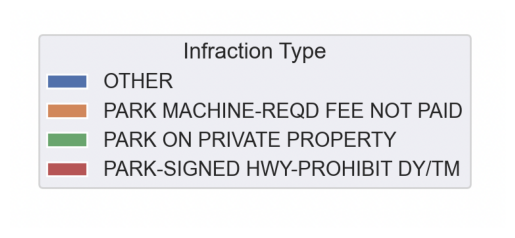

In [6]:
# since there are many to visualize, get the top most 
# frequent N infractions in dataset.
top_infractions = set(
    df['infraction_description']
      .value_counts()
      .nlargest(settings.get('top_n_infractions', 3))
      .keys()
)

# NOTE: Figure out how to display standalone & common legend.
# Resolving these issues: (1) show legend before plots, (2)
# show multiple visuals per cell, (3) show legend figure. 

# show the legend from pre-generated image.
import matplotlib.image as mpimg
img = mpimg.imread('image/top_infractions_legend.png')
plt.imshow(img)
plt.axis('off')
plt.show()
'''
# construct lengend depends on plot axis.
fig_legend = plt.figure()
handles, labels = ax.get_legend_handles_labels()
fig_legend.legend(
    handles,
    labels,
    title="Infraction Type",
    loc='center',
)
fig_legend.show()
''';

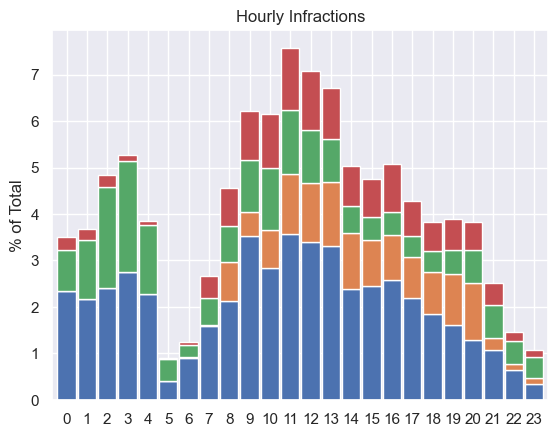

In [7]:
ax = plot_histogram_infractions(df, period='hour', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Hourly Infractions",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Activity throughout the day reveals:

1. _most infractions occur at lunchtime_ <br>
Presumably this is when most of the population (& parking ticket staff) are active to commit infractions & be caught.

1. _unpaid meter infractions happen only during the day_ <br>

1. _parking on private property is more problematic at night_ <br>

1. _abnormal number of violations in the early morning_ <br>
At days end, we would expect a similar number of violations between consiecutives hours. However between 12am - 4am, there is an unexplainable excess distribution of activity. Perhaps this is freight & trucking related to city by-laws, OR perhaps this is a mismatch in time of recording. More investigation is requried.

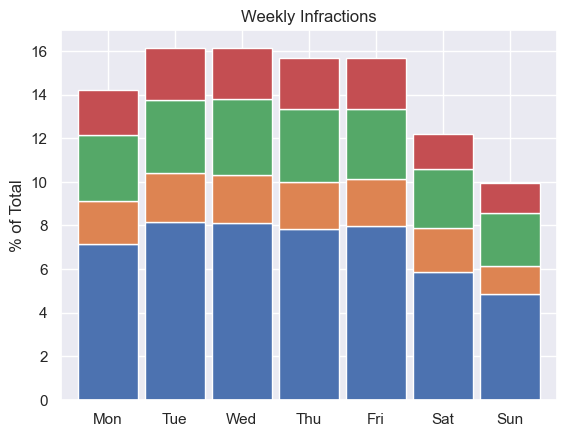

In [8]:
ax = plot_histogram_infractions(df, period='day', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Weekly Infractions",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Parking activity throughout the week reveals:
1. _less activity is seen on weekends_ <br>
> **⚠️ _NOTE:_** 
Perhaps there is a sampling bias here as there might be less staff working on weekends to catch violations or there is trully less driving activity occuring on the weekends. More data is needed to tease out.

1. _consistent daily behaviour_ <br>
Eventhough week vs weekend infraction volumes change a bit in abosolut, the proportional breakdown of infractions each day are identical suggesting public behaviour remains constant throughout the week.






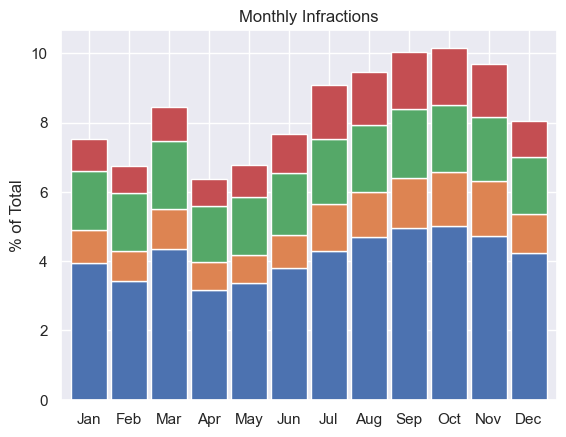

In [9]:
ax = plot_histogram_infractions(df, period='month', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Monthly Infractions",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Parking activity throughout the year reveals:

1. _seasonality trends exist_ <br>
With late summer & early fall showing the most violations, this can be explained by tourism & back-to-school behaviours.

1. _march activity is abnormaly inflated_ <br>
> **⚠️ _NOTE:_** 
Perhaps the fiscal cycle for the City of Toronto starts in April (tax time) which could explain the spike in reported traffic violations. Further analysis is needed.

#### 📐 Parking Quotas
<p style="background: #DAF7A6;padding: 10px;-moz-border-radius: 10px;-webkit-border-radius: 10px;-o-border-radius: 10px;-ms-border-radius: 10px;border-radius: 10px;">Is there evidence that parking violations are issued in certain areas at certain perriods to meet city quotas?</p>


<Axes: title={'center': 'Typical Stats'}, xlabel='day in month', ylabel='infractions'>

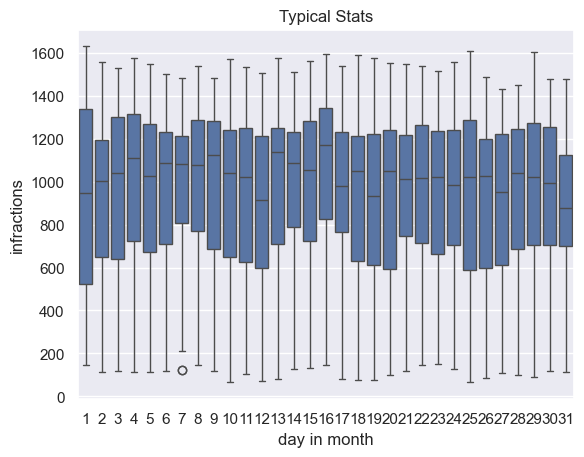

In [20]:
df_tmp = df['date_of_infraction'].value_counts().to_frame('current')
df_tmp['day_in_month'] = df_tmp.index.to_series().dt.day
df_tmp = df_tmp.dropna()
ax = sns.boxplot(x=df_tmp['day_in_month'], y=df_tmp['current'])
ax.set_title('Typical Stats');
ax.set_xlabel('day in month');
ax.set_ylabel('infractions');
display(ax)

To see if there are specific dates in the month with anomalous number of infractions we aggregate parking ticket statistics for each day. From the box plot, we notice that no daily distribution statistically deviates from the rest to suggest quotas being enforced. However, we notice that mid-month assigns the average number of tickets.
> **⚠️ _NOTE:_** 
Due to variable number of days in a month, (ie: Feb, vs 30 vs 31 day months) the tailing values have fewer datapoints.

#### 🧳 Local vs Foreign
<p style="background: #DAF7A6;padding: 10px;-moz-border-radius: 10px;-webkit-border-radius: 10px;-o-border-radius: 10px;-ms-border-radius: 10px;border-radius: 10px;">Are vehicles with foregin licenses equaly likely to get parking violations as local vehicles?</p>


> **⚠️ _NOTE:_** 
The dataset is heavily unbalanced towards local license places commiting most of the offences (97%). While this is to be expected analysis in this section needs to relatively compare local vs foreign groups.

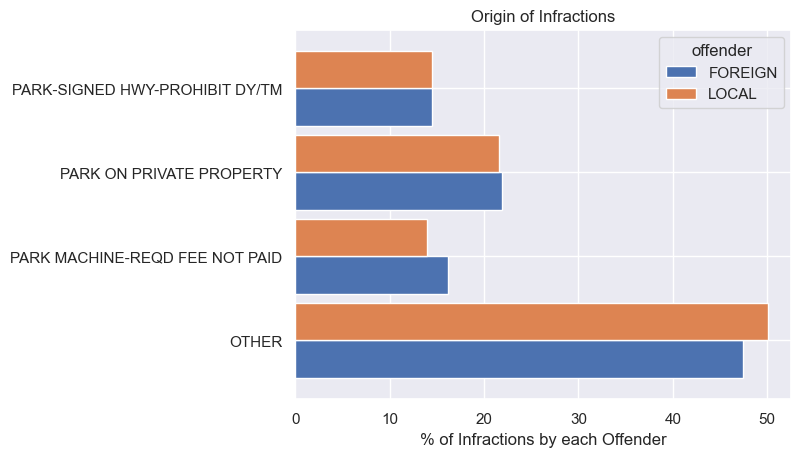

In [10]:
ax = plot_prejudice_by_type(df, top_infractions).plot(
    kind='barh', width=0.9,
    title="Origin of Infractions",
    ylabel="",
    xlabel='% of Infractions by each Offender',
)

1. _similar behaviours_ <br>
Both local & foreign offenders have a similar breakdown of infractions suggesting no major difference in each group's behaviour.

1. _foreign veicles more likely to not pay meters_ <br>
While most infraction rates are at par for each group, foreign licenses are 4% more likely to not pay parking meters.



#### 🦠 COVID Effects
<p style="background: #DAF7A6;padding: 10px;-moz-border-radius: 10px;-webkit-border-radius: 10px;-o-border-radius: 10px;-ms-border-radius: 10px;border-radius: 10px;">Where there changes in parking violations due to pandemic work-from-home behavours?</p>




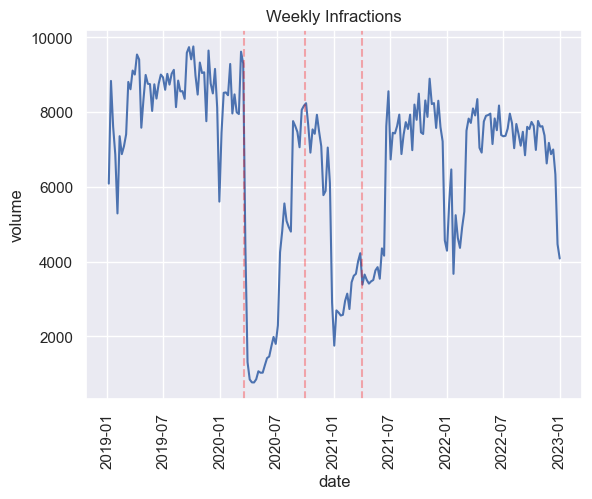

In [13]:
# time series of overal infractions per week.
ax = sns.lineplot(
    data=df.groupby(
        [pd.Grouper(key='date_of_infraction', freq='W')]
    ).size().to_frame('volume'),
)
ax.set_title('Weekly Infractions')
ax.set_xlabel('date')
ax.set_ylabel('volume')
ax.tick_params(axis='x', rotation=90)
ax.get_legend().set_visible(False)

# plot key time markers.
covid_shutdowns = {
    datetime(2020, 3, 17), # 1st wave
    datetime(2020, 10, 2), # 2nd preventive wave
    datetime(2021, 4, 3),  # 3rd emergency wave
}
for d in covid_shutdowns:
    ax.axvline(
        x=d, 
        linestyle='dashed',
        color='red',
        alpha=0.3
    )

Based on [wikipedia's](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Toronto) timeline of COVID shutdowns in Toronto (denoted by doted red vertical lines), we see the volume of parking violations were imediately affected in each of the pandemic waves.